In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import os
import sklearn

from sklearn import linear_model
from scipy import stats

from sklearn.linear_model import LinearRegression
from geopy.distance import distance

In [221]:
class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """

#     def __init__(self, *args, **kwargs):
#         if not "fit_intercept" in kwargs:
#             kwargs['fit_intercept'] = False
#         super(LinearRegression, self)\
#                 .__init__(*args, **kwargs)
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True,
                 n_jobs=1):
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.n_jobs = n_jobs

    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)

        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
#         se = np.array([
#             np.sqrt(np.diagonal(sse[i] * np.linalg.inv(np.dot(X.T, X))))
#                                                     for i in range(sse.shape[0])
#                     ])
        se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])

        self.t = self.coef_ / se
        self.p = 2 * (1 - stats.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1]))
        return self

In [222]:
DATA_DIR = "../datasets_full"
LONDON_BOROUGH_SHAPES = "./statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp"

In [292]:
earnings = pd.read_csv(os.path.join(DATA_DIR, 'London', 'london_economic_activity.csv'))

In [293]:
earnings.drop('confidence', axis=1, inplace=True)
earnings.dropna(inplace=True)

In [294]:
def getYear(series):
    series['year'] = int(series['year'][-4:])
    return series

In [295]:
earnings = earnings.apply(getYear, axis=1)

In [296]:
earnings.head()

,year,area_code,area,gender,economically_active,working_age,percent
0,2005,00AA,City of London,F,2400.0,3600.0,64.4
3,2008,00AA,City of London,F,1200.0,1200.0,100.0
11,2016,00AA,City of London,F,2800.0,2800.0,100.0
12,2017,00AA,City of London,F,3500.0,6200.0,56.9
13,2018,00AA,City of London,F,2500.0,3200.0,77.6


In [297]:
earnings_per_area = earnings.pivot_table(index='area', columns='year', values='economically_active')

In [298]:
earnings_per_area.head()

year,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
area,,,,,,,,,,,,,,,
Barking and Dagenham,36200.0,36100.0,38300.0,38300.0,39350.0,41700.0,42550.0,43500.0,45300.0,44750.0,47050.0,47100.0,49100.0,49250.0,50950.0
Barnet,79850.0,80200.0,79800.0,81250.0,81900.0,86800.0,88150.0,88400.0,92250.0,89950.0,92150.0,91950.0,98450.0,96500.0,101500.0
Bexley,55900.0,55850.0,54900.0,55750.0,55200.0,56400.0,56100.0,57950.0,58400.0,59850.0,61900.0,63500.0,61550.0,61900.0,62100.0
Brent,66100.0,66100.0,72850.0,75800.0,77700.0,74150.0,75700.0,80350.0,81200.0,79000.0,82650.0,84000.0,83500.0,82700.0,84950.0
Bromley,78200.0,76100.0,79800.0,78450.0,77400.0,75250.0,77750.0,78200.0,81150.0,80300.0,80600.0,82100.0,84000.0,84150.0,84800.0


In [299]:
earnings_per_area.interpolate(inplace=True)

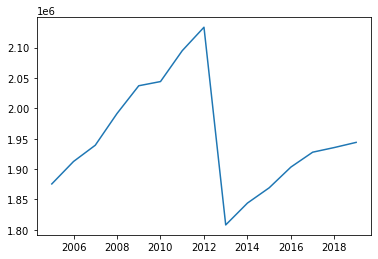

In [300]:
plt.plot(earnings_per_area.loc['London'])

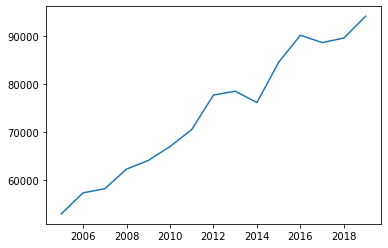

In [301]:
plt.plot(earnings_per_area.loc['Newham'])

Find difference in slopes before and after olympics
===================================================

In [302]:
before_olympics = earnings_per_area.loc[:, :2012]
after_olympics = earnings_per_area.loc[:, 2012:]

In [303]:
def get_slope(series):
    regressor = LinearRegression()
    
    indices = series.index.to_numpy().reshape(-1, 1)
    regressor.fit(indices, series)
    
    return regressor.coef_[0]

In [304]:
before_olympics.loc['Newham'].index.to_numpy()

array([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012])

In [305]:
before_olympics.loc['Newham'].to_numpy()

array([52900., 57300., 58150., 62250., 64050., 66950., 70500., 77700.])

In [306]:
regressor = LinearRegression()

regressor.fit(before_olympics.loc['Newham'].index.to_numpy().reshape(-1, 1), before_olympics.loc['Newham'].to_numpy())

LinearRegression()

In [307]:
regressor.intercept_

-6339564.285714285

In [308]:
regressor.predict([[2005]])

array([52566.66666667])

In [309]:
before_slopes = before_olympics.apply(get_slope, axis=1)
after_slopes = after_olympics.apply(get_slope, axis=1)

before_slopes = before_slopes.rename('before')
after_slopes = after_slopes.rename('after')

In [310]:
slopes = pd.concat([before_slopes, after_slopes], axis=1)

slopes['diff'] = (slopes['after'] - slopes['before']) / earnings_per_area.mean(axis=1)

In [311]:
slopes.head()

,before,after,diff
area,,,
Barking and Dagenham,1126.190476,1011.904762,-0.002639
Barnet,1443.452381,1645.833333,0.002284
Bexley,232.738095,633.928571,0.006860
Brent,1827.976190,649.404762,-0.015152
Bromley,-76.785714,878.571429,0.011959


In [312]:
slopes.loc['City of London']['diff'] = 0.

Load london borough shape data
==============================

In [313]:
map_df = gpd.read_file(LONDON_BOROUGH_SHAPES)
map_df = map_df.to_crs('epsg:3857')

In [314]:
map_df.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((-36811.020 6679699.611, -36801.601 6..."
1,Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((-7126.807 6677851.759, -7132.828 667..."
2,Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((1350.415 6674461.413, 1331.568 66744..."
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((-27224.557 6708199.030, -27237.660 6..."
4,Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((-45845.001 6716316.317, -45850.623 6..."


In [315]:
locations = pd.DataFrame({
    'Name': ['Olympic Park'],
    'Latitude': [51.54615],
    'Longitude': [-0.01269]
})

In [316]:
geo_locs = gpd.GeoDataFrame(locations, geometry=gpd.points_from_xy(locations.Longitude, locations.Latitude), crs="EPSG:4326")

In [317]:
geo_locs = geo_locs.to_crs('epsg:3857')

/Users/edwardli/anaconda3/envs/datathon/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  This is separate from the ipykernel package so we can avoid doing imports until


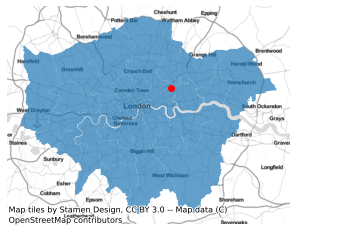

In [318]:
ax = map_df.plot(alpha=0.7)
geo_locs.plot(ax=ax, color='red', label="test", legend="bottomright")
ctx.add_basemap(ax, zoom=10, url=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

Plot merged data
================

In [319]:
merged = map_df.set_index('NAME').join(slopes)

/Users/edwardli/anaconda3/envs/datathon/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  after removing the cwd from sys.path.


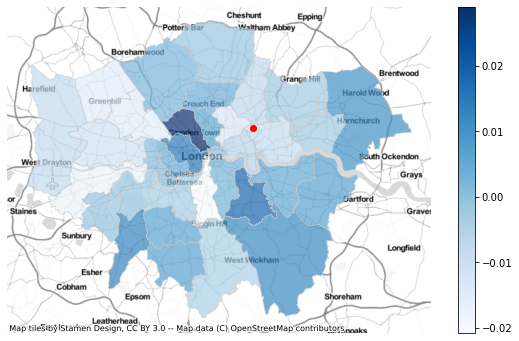

In [320]:
fig, ax = plt.subplots(1, figsize=(10, 6))
merged.plot(column='diff', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', alpha=0.7, legend=True)
geo_locs.plot(ax=ax, color='red', label="test", legend=True)
ctx.add_basemap(ax, zoom=10, url=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

In [321]:
merged['before'] = merged['before'] / earnings_per_area.mean(axis=1)

In [322]:
merged['before']['City of London'] = 0

/Users/edwardli/anaconda3/envs/datathon/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [323]:
merged['before']

NAME
Kingston upon Thames      0.003327
Croydon                   0.010879
Bromley                  -0.000961
Hounslow                  0.021282
Ealing                    0.014251
Havering                  0.006170
Hillingdon                0.020232
Harrow                    0.015431
Brent                     0.023501
Barnet                    0.016291
Lambeth                   0.034600
Southwark                 0.028695
Lewisham                  0.010854
Greenwich                 0.021447
Bexley                    0.003980
Enfield                   0.011979
Waltham Forest            0.029298
Redbridge                 0.017244
Sutton                    0.004829
Richmond upon Thames      0.002915
Merton                    0.005964
Wandsworth                0.015339
Hammersmith and Fulham    0.001774
Kensington and Chelsea   -0.014984
Westminster              -0.000518
Camden                    0.004911
Tower Hamlets             0.044101
Islington                 0.029642
Hackney        

In [324]:
dists = pd.read_csv('region_distances.csv').set_index('NAME')

In [325]:
mdists = map_df.set_index('NAME').join(dists)

/Users/edwardli/anaconda3/envs/datathon/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  after removing the cwd from sys.path.


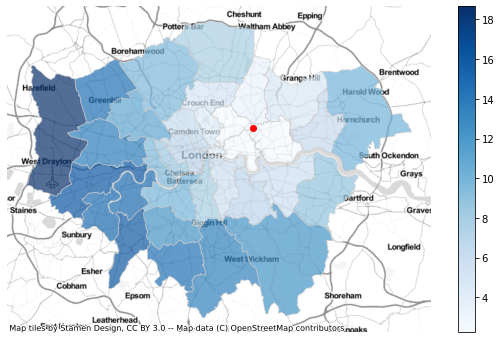

In [326]:
fig, ax = plt.subplots(1, figsize=(10, 6))
mdists.plot(column='Distance', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', alpha=0.7, legend=True)
geo_locs.plot(ax=ax, color='red', label="test")
ctx.add_basemap(ax, zoom=10, url=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

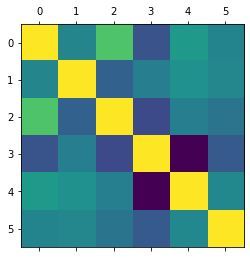

In [327]:
plt.matshow(mdists.join(slopes).corr())

In [328]:
mdists.join(slopes).corr()

,HECTARES,NONLD_AREA,Distance,before,after,diff
HECTARES,1.000000,0.032552,0.509195,-0.318459,0.175957,0.022222
NONLD_AREA,0.032552,1.000000,-0.228227,-0.019567,0.122055,0.044099
Distance,0.509195,-0.228227,1.000000,-0.379135,-0.013085,-0.090373
before,-0.318459,-0.019567,-0.379135,1.000000,-0.777166,-0.274754
after,0.175957,0.122055,-0.013085,-0.777166,1.000000,0.050976
diff,0.022222,0.044099,-0.090373,-0.274754,0.050976,1.000000


In [329]:
profiles = pd.read_csv('london-borough-profiles.csv', encoding='ISO-8859-2')

In [330]:
profiles.set_index('Area_name').loc['Newham']

Code                                                            E09000025
Inner/_Outer_London                                          Inner London
GLA_Population_Estimate_2017                                       342900
GLA_Household_Estimate_2017                                        119172
Inland_Area_(Hectares)                                              3,620
                                                                 ...     
Political_control_in_council                                          Lab
Proportion_of_seats_won_by_Conservatives_in_2014_election               0
Proportion_of_seats_won_by_Labour_in_2014_election                    100
Proportion_of_seats_won_by_Lib_Dems_in_2014_election                    0
Turnout_at_2014_local_elections                                      40.5
Name: Newham, Length: 83, dtype: object

In [331]:
profiles.set_index('Area_name').join(slopes).corr().loc['diff']

GLA_Population_Estimate_2017                          0.001578
Average_Age,_2017                                     0.305693
Proportion_of_population_aged_0-15,_2015             -0.118275
Proportion_of_population_of_working-age,_2015        -0.128065
Proportion_of_population_aged_65_and_over,_2015       0.260420
New_migrant_(NINo)_rates,_(2015/16)                  -0.271586
Employment_rate_(%)_(2015)                           -0.002084
%_of_employment_that_is_in_public_sector_(2014)      -0.033761
Jobs_Density,_2015                                    0.021679
Number_of_active_businesses,_2015                    -0.009728
Two-year_business_survival_rates_(started_in_2013)    0.143337
Number_of_cars,_(2011_Census)                         0.013874
Number_of_cars_per_household,_(2011_Census)           0.010814
%_children_living_in_out-of-work_households_(2015)   -0.045952
Life_satisfaction_score_2011-14_(out_of_10)           0.140962
Worthwhileness_score_2011-14_(out_of_10)              0

In [332]:
profiles.set_index('Area_name').join(dists).corr().loc['Distance']

GLA_Population_Estimate_2017                          0.035107
Average_Age,_2017                                     0.416243
Proportion_of_population_aged_0-15,_2015              0.142736
Proportion_of_population_of_working-age,_2015        -0.535341
Proportion_of_population_aged_65_and_over,_2015       0.549599
New_migrant_(NINo)_rates,_(2015/16)                  -0.468055
Employment_rate_(%)_(2015)                            0.530636
%_of_employment_that_is_in_public_sector_(2014)      -0.316548
Jobs_Density,_2015                                   -0.201112
Number_of_active_businesses,_2015                    -0.197319
Two-year_business_survival_rates_(started_in_2013)    0.566712
Number_of_cars,_(2011_Census)                         0.570414
Number_of_cars_per_household,_(2011_Census)           0.715940
%_children_living_in_out-of-work_households_(2015)   -0.610379
Life_satisfaction_score_2011-14_(out_of_10)           0.480959
Worthwhileness_score_2011-14_(out_of_10)              0

In [333]:
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

In [334]:
fa = FactorAnalyzer()

In [335]:
all_things = profiles.set_index('Area_name').join(dists).join(slopes)

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

newdf = all_things.select_dtypes(include=numerics)
newdf.dropna(inplace=True)

/Users/edwardli/anaconda3/envs/datathon/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [336]:
x_test = newdf.drop(['before', 'after', 'diff', 'Proportion_of_population_aged_0-15,_2015', 'Proportion_of_population_of_working-age,_2015', 'Proportion_of_population_aged_65_and_over,_2015'], axis=1)

In [337]:
reg_diff = LinearRegression()

reg_diff.fit(x_test, newdf['diff'])

LinearRegression()

In [338]:
reg_diff.coef_

array([ 5.99591754e-08,  3.04279726e-03,  1.42919114e-04,  1.12934860e-05,
        6.55027464e-04, -2.08581594e-04,  4.82092139e-07,  1.62761383e-03,
       -3.96041117e-07,  6.20201406e-02,  2.01108210e-03, -1.92596823e-02,
        3.17106916e-02,  3.32990911e-03,  3.40652771e-03, -5.50728423e-03,
       -9.85746307e-04])

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 <a list of 17 Text major ticklabel objects>)

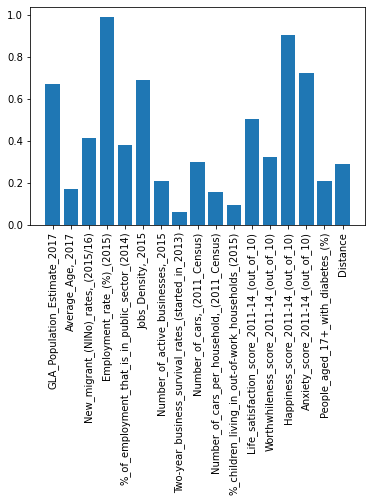

In [339]:
plt.bar(x_test.columns, reg_diff.p[0])
plt.xticks(rotation=90)

In [340]:
reg_second = LinearRegression()
reg_second.fit(newdf[['New_migrant_(NINo)_rates,_(2015/16)', 'Jobs_Density,_2015']], newdf['diff'])

LinearRegression()

In [341]:
sklearn.metrics.r2_score(newdf['diff'], reg_second.predict(newdf[['New_migrant_(NINo)_rates,_(2015/16)', 'Jobs_Density,_2015']]))

0.13983610092210963

In [342]:
reg_diff.p[reg_diff.p < 0.05]

array([], dtype=float64)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 <a list of 17 Text major ticklabel objects>)

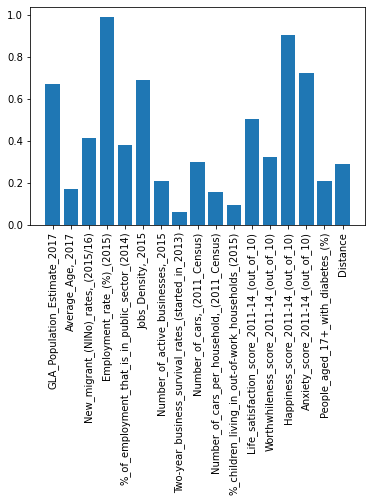

In [343]:
plt.bar(x_test.columns, abs(reg_diff.p[0]))
plt.xticks(rotation=90)

In [344]:
y_preds = reg_diff.predict(x_test)

In [345]:
sklearn.metrics.r2_score(newdf['diff'], y_preds)

0.6156767673140933

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 <a list of 17 Text major ticklabel objects>)

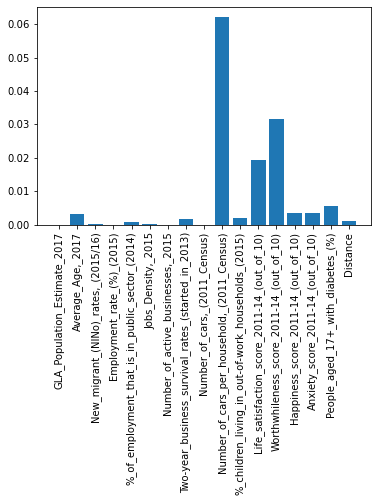

In [346]:
plt.bar(x_test.columns, abs(reg_diff.coef_))
plt.xticks(rotation=90)

In [347]:
fa.fit(newdf)

FactorAnalyzer(rotation_kwargs={})

[Text(0, 0, 'GLA_Population_Estimate_2017'),
 Text(0, 0, 'Average_Age,_2017'),
 Text(0, 0, 'Proportion_of_population_aged_0-15,_2015'),
 Text(0, 0, 'Proportion_of_population_of_working-age,_2015'),
 Text(0, 0, 'Proportion_of_population_aged_65_and_over,_2015'),
 Text(0, 0, 'New_migrant_(NINo)_rates,_(2015/16)'),
 Text(0, 0, 'Employment_rate_(%)_(2015)'),
 Text(0, 0, '%_of_employment_that_is_in_public_sector_(2014)'),
 Text(0, 0, 'Jobs_Density,_2015'),
 Text(0, 0, 'Number_of_active_businesses,_2015'),
 Text(0, 0, 'Two-year_business_survival_rates_(started_in_2013)'),
 Text(0, 0, 'Number_of_cars,_(2011_Census)'),
 Text(0, 0, 'Number_of_cars_per_household,_(2011_Census)'),
 Text(0, 0, '%_children_living_in_out-of-work_households_(2015)'),
 Text(0, 0, 'Life_satisfaction_score_2011-14_(out_of_10)'),
 Text(0, 0, 'Worthwhileness_score_2011-14_(out_of_10)'),
 Text(0, 0, 'Happiness_score_2011-14_(out_of_10)'),
 Text(0, 0, 'Anxiety_score_2011-14_(out_of_10)'),
 Text(0, 0, 'People_aged_17+_with_d

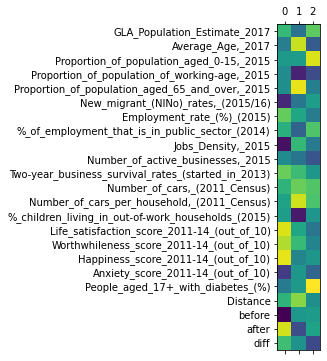

In [348]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.matshow(fa.loadings_)
ax.set_yticks(range(len(newdf.columns)))
ax.set_yticklabels(newdf.columns)

In [349]:
fa.loadings_

array([[ 0.33148104, -0.23659004,  0.49651029],
       [-0.14250937,  0.8195875 , -0.41205851],
       [ 0.06902864,  0.10198406,  0.87987971],
       [-0.03897237, -0.80285167, -0.52056201],
       [-0.0052797 ,  0.92286009, -0.13851392],
       [-0.77165503, -0.21678471,  0.10759187],
       [ 0.51741093,  0.17253732, -0.15006522],
       [ 0.26523286, -0.36054705,  0.4415457 ],
       [-0.90151896,  0.32804558, -0.17915608],
       [-0.03003175, -0.21907409, -0.45967183],
       [ 0.53514084,  0.36290226,  0.05916131],
       [ 0.29341503,  0.54277564,  0.44770054],
       [ 0.15098283,  0.84884992,  0.43119753],
       [ 0.11365434, -0.84673826,  0.0463957 ],
       [ 0.88060707,  0.16999571, -0.21455832],
       [ 0.75048696,  0.34569532, -0.09957743],
       [ 0.91841225, -0.09161547,  0.05593347],
       [-0.64569041,  0.05886561, -0.34425638],
       [-0.17754212,  0.07366023,  0.98870245],
       [ 0.2960781 ,  0.63474542, -0.00690144],
       [-0.99119849,  0.06426402,  0.100

In [350]:
calculate_kmo(newdf)

(array([0.50442938, 0.51845689, 0.46973832, 0.4959304 , 0.43286643,
        0.6439741 , 0.44085787, 0.44276654, 0.54408081, 0.31521546,
        0.55270867, 0.65769353, 0.68957448, 0.57927684, 0.54742719,
        0.58534479, 0.80076157, 0.88292473, 0.53564904, 0.76251952,
        0.51952217, 0.53074987, 0.13397688]),
 0.546950914832727)

In [351]:
calculate_bartlett_sphericity(newdf)

(1324.1700088358066, 7.231886180375157e-145)

In [352]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer()
fa.fit(newdf, 25)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

array([9.21552937e+00, 5.30076579e+00, 2.49816298e+00, 1.31112784e+00,
       1.17018375e+00, 9.39788057e-01, 6.88490041e-01, 4.40514184e-01,
       3.26621652e-01, 3.09437400e-01, 2.22666218e-01, 1.64282972e-01,
       1.44447643e-01, 1.00235835e-01, 6.63140838e-02, 4.07316906e-02,
       2.55606232e-02, 1.59963152e-02, 1.31109961e-02, 3.89607697e-03,
       1.92669520e-03, 1.98691307e-04, 1.11082144e-05])

In [353]:
earnings_per_area.head()

year,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
area,,,,,,,,,,,,,,,
Barking and Dagenham,36200.0,36100.0,38300.0,38300.0,39350.0,41700.0,42550.0,43500.0,45300.0,44750.0,47050.0,47100.0,49100.0,49250.0,50950.0
Barnet,79850.0,80200.0,79800.0,81250.0,81900.0,86800.0,88150.0,88400.0,92250.0,89950.0,92150.0,91950.0,98450.0,96500.0,101500.0
Bexley,55900.0,55850.0,54900.0,55750.0,55200.0,56400.0,56100.0,57950.0,58400.0,59850.0,61900.0,63500.0,61550.0,61900.0,62100.0
Brent,66100.0,66100.0,72850.0,75800.0,77700.0,74150.0,75700.0,80350.0,81200.0,79000.0,82650.0,84000.0,83500.0,82700.0,84950.0
Bromley,78200.0,76100.0,79800.0,78450.0,77400.0,75250.0,77750.0,78200.0,81150.0,80300.0,80600.0,82100.0,84000.0,84150.0,84800.0


In [354]:
olympic_boroughs = ['Newham', 'Barking and Dagenham', 'Greenwich', 'Hackney', 'Tower Hamlets', 'Waltham Forest']

In [355]:
normalized_people = earnings_per_area.div(earnings_per_area[2005], axis=0)

In [356]:
def split_olympics(series):
    
    return pd.Series({
        'olympic_avg': series[olympic_boroughs].mean(),
        'nonolympic_avg': series[~series.index.isin(olympic_boroughs)].mean()
    })

In [357]:
income_info = normalized_people.apply(split_olympics)

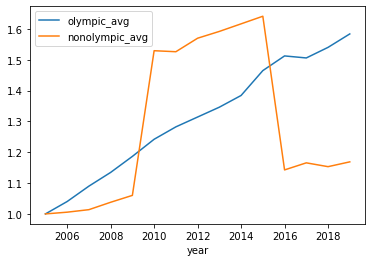

In [358]:
income_info.transpose().plot.line()